# Collaboration and Competition

-----

This notebook explores and solves the third project in the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program called Collaboration and Competition.
This project involves learning in an environment with multiple agents. The starter code for this project can be found [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/p3_collab-compet).

### 1. Import / Setup all necessary packages and notebook variables

If you have any trouble importing these packages make sure you check the README file and have all the necessary dependencies.
**Note:** To set up the unity environment the UnityEnvironment(filepath) must match the location of the Unity environment that you downloaded from the README.

In [1]:
from unityagents import UnityEnvironment
from agents import MADDPG
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

#----- Setup Notebook Variables -----#
path = os.path.abspath(os.getcwd())
env = UnityEnvironment(f'{path}\\Tennis_Windows_x86_64\\Tennis.exe')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
examine_environment = True
train_agent = False
view_results = True
watch_trained = True

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the environment

In this environment, two agents control rackets to bounce a ball over a net.
If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.
Thus, this is a cooperative environment and the goal of each agent is to keep the ball in play.

The observation space consists of variables corresponding to the position and velocity of the ball and racket.
Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Below is additional information about the environment

In [2]:
if examine_environment:
    #-------         Environment Details        -------#
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    action_size = brain.vector_action_space_size
    states = env_info.vector_observations
    state_size = states.shape[1]
    print(f'Number of agents: {num_agents}')
    print(f'Size of each action per agent: {action_size}')
    print(f'Size of observation space per agent: {state_size}')
    print(f'Example State: {states[0]}')

    #-------        Watch Untrained Agent     -------#
    for i in range(1, 7):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        while True:
            actions = np.random.randn(num_agents, action_size)
            actions = np.clip(actions, -1, 1)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break

        # Show Example of what environment returns
        if i == 1:
            print(f'Shape of states: {states.shape}, Shape of next_states: {next_states.shape}')
            print(f'Action Example: {actions}')
            print(f'Example of rewards: {rewards}')
            print(f'Example of Dones: {dones}')


Number of agents: 2
Size of each action per agent: 2
Size of observation space per agent: 24
Example State: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Shape of states: (2, 24), Shape of next_states: (2, 24)
Action Example: [[ 0.7069718  -1.        ]
 [ 0.17241884  0.96656906]]
Example of rewards: [0.0, -0.009999999776482582]
Example of Dones: [True, True]


### 3. Train an Agent

In [3]:
if train_agent:
    env_info = env.reset(train_mode=True)[brain_name]
    maddpg_agent = MADDPG(env_info.vector_observations.shape[1], brain.vector_action_space_size, len(env_info.agents), epsilon=1.0, seed=1)
    maddpg_agent.train(env,brain_name)


### 4. Show Results of Training

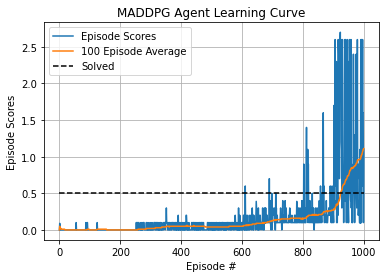

In [4]:
def graph_results(scores_filename, avgScores_filename, save_graph = True):
    """ Graph results from training an Agent

    :param scores_filename: filepath with episode scores
    :param avgScores_filename: filepath with average (per 100) episode scores
    :param save_graph: Bool for saving or just viewing graph
    """
    # Read in scores from the files
    with open(scores_filename) as f:
        scores = [round(float(score),2) for score in f.read().splitlines()]
    with open(avgScores_filename) as f:
        avg_scores = [round(float(score),2) for score in f.read().splitlines()]

    # Graph results
    fig, ax = plt.subplots()
    ax.set(xlabel="Episode #", ylabel="Episode Scores", title="MADDPG Agent Learning Curve")
    ax.grid()
    ax.plot(np.arange(len(scores)), scores, label="Episode Scores")
    ax.plot(np.arange(len(avg_scores)), avg_scores, label="100 Episode Average")
    ax.plot(np.arange(len(scores)), np.ones(len(scores))*0.5, color="black", linestyle="dashed", label="Solved")
    ax.legend()
    # Save graph results
    if save_graph:
        fig.savefig(f'{path}\images\MADDPG_results.png')
    plt.show()

def watch_trained(maddpg_agent, env, brain_name):
    """ Watch a trained agent interact in the environment. This agent will load the most recent checkpoints in checkpoints directory.

    :param agents: Agents used to learn and interact in the environment
    :param env: Unity environment for agent to act in
    :param brain_name: Brain of environment
    """
    # Load in agents trained parameters
    for agent_num,agent in enumerate(maddpg_agent.agents):
        agent.actor_local.load_state_dict(torch.load(f'{path}\checkpoints\DDPG_Agent_{agent_num}_Actor.pth'))

    # Watch the trained Agent
    for episode in range(5):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        for t in range(300):
            actions = maddpg_agent.act(states, maddpg_agent.epsilon)
            env_info = env.step(actions)[brain_name]
            next_states, dones = env_info.vector_observations, env_info.local_done
            states = next_states
            if np.any(dones):
                break

if view_results:
    graph_results(f'{path}\scores\MADDPG_Agent_Scores.txt',
                  f'{path}\scores\MADDPG_Agent_AvgScores.txt')

if watch_trained:
    env_info = env.reset(train_mode=False)[brain_name]
    agents = MADDPG(state_size= env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, num_agents=len(env_info.agents), epsilon=0, seed = 2)
    watch_trained(agents, env, brain_name)


When finished close the environment.

In [5]:
env.close()